# What Is My Music Taste?
## An Analysis using Spotify API

Whenever anyone asks me, "so what type of music do you listen to?", my usual answer is "... uh everything?". Having grown up with a very intense classical music training, my music taste ranges from Dvorak Symphonies, to early 2000's punk rock, to jazz ensembles. This project aims to quantify what type of music I listen to according to my Spotify playlists, to see if there are any features or combinations of features that make a song a "Lucy" song. I will be using the Spotify API to access my own user data, and to access public data. 

# 1. Data Acquisition

## 1.1 Installing Necessary Packages

In [361]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import simplejson as json
import time
import sys
import pandas as pd
from dateutil.parser import parse as parse_date
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats import ttest_1samp, ttest_ind

%matplotlib inline
sns.set_palette("husl")

In [212]:
import pandas_profiling

## 1.2 Accessing the Spotify API, Credentials Flow

In [2]:
# Credentials
cid ="CLIENT_ID" 
secret = "CLIENT_SECRET"
username = "USERNAME"
url = 'http://localhost:8888/'

For different types of access, the API requires different Scopes to be used. This will require going through the authorization flow a few times in order to collect all relevant data. The first scope I will use is "playlist-read-collaborative", which will read in all of my playlists including those that are collaborative

In [33]:
scope = 'playlist-read-collaborative'
token = util.prompt_for_user_token(username, scope, client_id = cid, client_secret = secret, redirect_uri = url)
sp = spotipy.Spotify(auth=token)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=b898efb513404bbd9158d441fde9e72d&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A8888%2F&scope=playlist-read-collaborative in your browser


Enter the URL you were redirected to: http://localhost:8888/tree?code=AQACh5ERDpRiW9TukF9YqqyfitbEKzM8Qb1FDfcbAgXdJjN5gJf4yHNMcSuWnDMs7-LE2Sj4HLugA4kKl80CSXPWuTs5ejg5oL90YA3NzZ8zPK_fQVH_SXOSNtlo84rul5uTvk30rWhEjFDK02zXPHKpLpiODDgrXKl31CTBvQAHjFM7TAFe6PiUkvi3-RnlmrTtT1cnd5aMwciJFf0QzxNuHOi9Dv-8Fw




## 1.3 Reading in Playlist Tracks

My Method here was to create a list of all of my playlists' uris, and write a function that extracts the tracks and relevant information from each playlist, and finally appending all info to a dataframe. 

In [205]:
# Creating a list of all playlist URIs
playlists = sp.user_playlists(username)
playlist_list = []
for i, playlist in enumerate(playlists['items']):
    playlist_list.append(playlist['uri'])

SpotifyException: http status: 401, code:-1 - https://api.spotify.com/v1/users/luicyfruit/playlists?limit=50&offset=0:
 The access token expired

In [37]:
playlist_list

['spotify:playlist:053c3pcBU8Pt1pJ6054Ecl',
 'spotify:playlist:67AaHjXPxchILEUYo6U6Jc',
 'spotify:playlist:1Ws692DbZXeZaO3TwKYD7f',
 'spotify:playlist:7D9fBCEzxoBUjAr5WQsoVG',
 'spotify:playlist:1l8gT6RmIEQuX5tofIfhSo',
 'spotify:playlist:2eIt1JGk1P2gfeShUbKxM6',
 'spotify:playlist:7v6RFIACWKDeujg78HJs9i',
 'spotify:playlist:1aH2G6406gIHWxBw2hF49M',
 'spotify:playlist:245rac8tbWuHLZyAJsytEE',
 'spotify:playlist:6Oro0JjkiIL2C8RbJk7MQR',
 'spotify:playlist:6jSfnqgdAChQfkN0k5FktO',
 'spotify:playlist:6pj5lkVJFRP0gOKITCPS2u',
 'spotify:playlist:6iWibsabjdgwKOjSm33PiQ',
 'spotify:playlist:2Hm1Nt9iARci8Q2K3LbxrJ',
 'spotify:playlist:3gk5Xdgv2g87RNfZIGHVDI',
 'spotify:playlist:2QheVJqhaEz0WFApCB34IO',
 'spotify:playlist:1irRM6uWXe2KeLKO7X5Oqy',
 'spotify:playlist:0eCudGfWHFF7fxHtlIYSWl',
 'spotify:playlist:3Bl7Il4Zk4wa1M2q4ffoOj']

Since I will be reading in multiple playlists, writing a function made this easier. For each track, I wanted to extract the track uri, the artist, the name, it's popularity score, the release date, and the date I added it to the playlist (i.e. an approximation of when I first discovered the song). 

In [38]:
# Function to read in the Tracks and some Attributes of each Playlist
def read_playlist(user, playlistID):
    c = ['uri', 'artist', 'name', 'popularity', 'release_date', 'added_at']
    playlist = sp.user_playlist(user, playlistID)
    tracks = playlist['tracks']['items']

    tracks_df = pd.DataFrame([(track['track']['uri'],
                           track['track']['artists'][0]['name'],
                           track['track']['name'],
                            track['track']['popularity'],
                           parse_date(track['track']['album']['release_date']) if track['track']['album']['release_date'] else None,
                           parse_date(track['added_at']))
                          for track in tracks], columns = c)
    return tracks_df

In [39]:
# Append all tracks into a singular Dataframe
playlist_df = pd.DataFrame(columns=['uri', 'artist', 'name', 'popularity', 'release_date', 'added_at'])
for p in playlist_list:
    y = read_playlist(username, p)
    playlist_df = playlist_df.append(y, ignore_index = True)
    

Now that we have all of the basic track information, I wanted to obtain some of the audio features on each track. This uses the sp.audio_features function, which takes in a track uri and returns information such as energy, loudness, key, tempo, and more. I then wanted to take that information and store it in a dataframe, so I wrote a function that takes in a list of track uris, and returns a dataframe full of their relevant information

In [42]:
# Function to get audio features from tracks
def audio_features(uris):
    c = ['uri',
     'danceability', 
     'energy', 
     'key', 
     'loudness', 
     'mode', 
     'speechiness',
     'acousticness',
     'instrumentalness', 
     'liveness', 
     'valence', 
     'tempo', 
     'duration_ms', 
     'time_signature']

    df = pd.DataFrame(columns = c)   
    for uri in uris:
        x = sp.audio_features(uri)
        data = [{'uri': x[0]['uri'],
             'danceability': x[0]['danceability'],
             'energy': x[0]['energy'],
             'key': x[0]['key'],
             'loudness': x[0]['loudness'],
             'mode': x[0]['mode'],
             'speechiness': x[0]['speechiness'],
             'acousticness': x[0]['acousticness'],
             'instrumentalness': x[0]['instrumentalness'],
             'liveness': x[0]['liveness'],
             'valence': x[0]['valence'],
             'tempo': x[0]['tempo'],
             'duration_ms': x[0]['duration_ms'],
             'time_signature': x[0]['time_signature']
            }]
        df = df.append(data, ignore_index = True, sort = False)
    return df

In [41]:
# Track URI List
track_uris = playlist_df['uri']

In [43]:
# Using function on playlist tracks
features_df = audio_features(track_uris)

retrying ...2secs


In [323]:
fiver = features_df.head()

In [325]:
print(tabulate(fiver, tablefmt="github", headers="keys"))

|    | uri                                  |   danceability |   energy |   key |   loudness |   mode |   speechiness |   acousticness |   instrumentalness |   liveness |   valence |   tempo |   duration_ms |   time_signature |
|----|--------------------------------------|----------------|----------|-------|------------|--------|---------------|----------------|--------------------|------------|-----------|---------|---------------|------------------|
|  0 | spotify:track:6xEHCWUvalb0fNYuAo591v |          0.487 |    0.787 |     5 |    -11.323 |      0 |        0.0945 |          0.761 |           0.871    |     0.109  |     0.424 |  74.916 |        283200 |                4 |
|  1 | spotify:track:6v96ZIpQUtWMSUqlBlTif6 |          0.567 |    0.377 |     0 |    -11.851 |      0 |        0.0783 |          0.709 |           0.802    |     0.103  |     0.563 | 120.927 |        227000 |                3 |
|  2 | spotify:track:62VWmsNoDmqT0Mj9oHHFVh |          0.701 |    0.445 |     1 |    -10

Great! Now that we have the two separate sets of information (basic track info and audio features) for each track in my playlists, I will merge them into a larger dataframe on their uri. 

In [45]:
# Combine the two dataframes
full = pd.merge(left = playlist_df, 
                right = features_df, 
                left_on = ['uri'], 
                right_on = ['uri'])

In [46]:
len(full)

539

## 1.4 Reading in Top Tracks 
This section reads in my top played tracks as I want to make sure that I'm not missing any music that I frequently listen to but isn't in my playlists. To start, this requires a new scope which requires me to go through the authorization flow again

In [111]:
# Requires new scope 
scope = 'user-top-read'
token = util.prompt_for_user_token(username, 
                                   scope, 
                                   client_id = cid, 
                                   client_secret = secret, 
                                   redirect_uri = url)
sp = spotipy.Spotify(auth=token)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=b898efb513404bbd9158d441fde9e72d&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A8888%2F&scope=user-top-read in your browser


Enter the URL you were redirected to: http://localhost:8888/tree?code=AQB9kNl37VfMPJxXuntgHYvBzvvF8jm4RCrNj4uMFVGgA5X4_lOV94RyLY3qnBl7QkGd793to1JOraT0wgak-2M9kGuP0p0NYM55jKsxQmwbJSmJx23w8hEMjBBJT_Z5zTDBnpcVvG60abqbji6v66Bpcii-SNgG7JuAETn8gb4HPoRECtQIrD0JU7GsBedgqAnWjJfi66LueOo




The Top Tracks scope requires a time range, which are categorized as follows:
**Short Term** is the last four weeks, **Medium Term** is the last 6 months, and **Long Term** is over a few years of data. I will use these time estimates as the "added_at" parameter to estimate when I first discovered that song

In [121]:
# Possible Ranges for a "Top Track"

ranges = ['short_term', 'medium_term', 'long_term']
# List of URIs 
c = ['uri','added_at'] 
top_tracks = pd.DataFrame(columns = c)

for r in ranges:
    if r == 'short_term': 
        d = parse_date('2020-01-01')
    elif r == 'medium_term':
        d = parse_date('2019-06-01')
    else: d = parse_date('2018-01-01')
        
    results = sp.current_user_top_tracks(time_range=r, limit=50)
    for i, item in enumerate(results['items']):
        data = [{'uri': item['uri'],
                'added_at': d}]
        top_tracks = top_tracks.append(data, ignore_index = True, sort = False)
        

In [122]:
top_tracks.head()

,uri,added_at
0,spotify:track:6WrI0LAC5M1Rw2MnX2ZvEg,2020-01-01
1,spotify:track:7qelz5hbyDGoeV8h02YkEE,2020-01-01
2,spotify:track:1dcaQEzJ1sU9ImjDHLV5mh,2020-01-01
3,spotify:track:4R7ZSlYoJOIaxHJFHszQCR,2020-01-01
4,spotify:track:1I7zHEdDx8Ny5RxzYPqsU2,2020-01-01
5,spotify:track:1YcdyD31mx74MF6zCcw0BN,2020-01-01
6,spotify:track:4Th9Lu8GK0mt5fZZ945FI7,2020-01-01
7,spotify:track:4kV4N9D1iKVxx1KLvtTpjS,2020-01-01
8,spotify:track:4usVYcPlxRgRet6YashdCJ,2020-01-01
9,spotify:track:7fqQ5zYIcNTFRJLrnSkKV4,2020-01-01


Since the function I wrote previously took in a list of playlists, I have tweaked it to account for the dataframe of tracks instead. Since they are not in a playlist, I will use the date estimated above as the "added_at" date. 

In [127]:
# Function to Read Tracks, rather than Playlists
def read_tracks(tracks_df):
    c = ['uri', 'artist', 'name', 'popularity', 'release_date', 'added_at']
    df = pd.DataFrame(columns = c)
    tracks = tracks_df['uri']
    for track in tracks:
        counter = 0
        t = sp.track(track)
        data = [{'uri': t['uri'],
        'artist': t['artists'][0]['name'],
        'name': t['name'],
        'popularity': t['popularity'],
        'release_date': parse_date(t['album']['release_date']) if t['album']['release_date'] else None,
        'added_at': tracks_df['added_at'][counter]}]
        df = df.append(data, ignore_index = True, sort = False)
        counter += 1
    return df
        

In [130]:
top_tracks_info = read_tracks(top_tracks)

retrying ...2secs


Next, I call the audio_features function on those tracks, and take the two dataframes (track info and track audio features) and merge them together, followed by adding them to the playlist dataframe created earlier

In [131]:
# Access Audio Features of the tracks
top_tracks_features = audio_features(top_tracks['uri'])

retrying ...1secs


In [132]:
top_tracks_df = pd.merge(left = top_tracks_info,
                        right = top_tracks_features,
                        left_on = ['uri'],
                        right_on = ['uri'])

In [133]:
top_tracks_df.head()

,uri,artist,name,popularity,release_date,added_at,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,spotify:track:6WrI0LAC5M1Rw2MnX2ZvEg,Dua Lipa,Don't Start Now,97,2019-10-31,2020-01-01,0.794,0.793,11,-4.521,0,0.0842,0.012500,0,0.0952,0.677,123.941,183290,4
1,spotify:track:6WrI0LAC5M1Rw2MnX2ZvEg,Dua Lipa,Don't Start Now,97,2019-10-31,2020-01-01,0.794,0.793,11,-4.521,0,0.0842,0.012500,0,0.0952,0.677,123.941,183290,4
2,spotify:track:6WrI0LAC5M1Rw2MnX2ZvEg,Dua Lipa,Don't Start Now,97,2019-10-31,2020-01-01,0.794,0.793,11,-4.521,0,0.0842,0.012500,0,0.0952,0.677,123.941,183290,4
3,spotify:track:6WrI0LAC5M1Rw2MnX2ZvEg,Dua Lipa,Don't Start Now,97,2019-10-31,2020-01-01,0.794,0.793,11,-4.521,0,0.0842,0.012500,0,0.0952,0.677,123.941,183290,4
4,spotify:track:7qelz5hbyDGoeV8h02YkEE,Tiffany,I Think We're Alone Now (Re-Recorded) [Remaste...,25,2012-01-17,2020-01-01,0.635,0.919,7,-5.044,1,0.0488,0.000178,0.00218,0.0897,0.619,130.288,226373,4


In [145]:
# Adding to Main Dataframe
master_df = full.append(top_tracks_df, ignore_index = True)

In [146]:
len(master_df)

743

## 1.5 Read in Saved Tracks

Lastly, I want to make sure I didn't miss any songs in my saved tracks. This requires a different scope and going through the authorization flow again. 

In [137]:
# Requires New Scope Again
scope = 'user-library-read'
token = util.prompt_for_user_token(username, 
                                   scope, 
                                   client_id = cid, 
                                   client_secret = secret, 
                                   redirect_uri = url)
sp = spotipy.Spotify(auth=token)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=b898efb513404bbd9158d441fde9e72d&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A8888%2F&scope=user-library-read in your browser


Enter the URL you were redirected to: http://localhost:8888/tree?code=AQA4dMiZFjGxiuRVggNR3wWsdZ2iqCNpvVd0RHeyQHNYr1gFdWKfcXdlSS2FDBJeD_qlNDqI3x7mQ23dlG2Sr9VPuO6Z0F1N2eFkSe-9PCm2tlVDtBdl6Irp369rDlxCVaj4V9ItgPVeNdPCBQxB3IQ5yR71LoZoACZrmroAihn__K46o3PLitnD10kseA3mCywn3R3ewhJK0-LRv4jD




I will use the current_user_saved_tracks function (which unfortunately has a limit of 20) to access any saved tracks I may have that aren't in my recently played or my playlists. The date I will use to estimate song discovery is the date I saved the track.

In [140]:
c = ['uri','added_at'] 
saved_tracks = pd.DataFrame(columns = c)

results = sp.current_user_saved_tracks()
for i, item in enumerate(results['items']):
    data = [{'uri': item['track']['uri'],
            'added_at': parse_date(item['added_at'])}]
    saved_tracks = saved_tracks.append(data, ignore_index = True, sort = False)

In [142]:
saved_tracks

,uri,added_at
0,spotify:track:6DwiGVCgXGREeCyJZtX7S1,2020-01-08 23:00:45+00:00
1,spotify:track:3yhInewGeB4AzUJKyz3SUR,2020-01-08 22:54:30+00:00
2,spotify:track:2WfaOiMkCvy7F5fcp2zZ8L,2019-12-10 16:40:27+00:00
3,spotify:track:6AUAxTW5k2vs63TN8BIRu2,2019-11-05 19:36:45+00:00
4,spotify:track:0Exmgtcwu1ZMOXt4rioXbo,2019-09-06 21:59:08+00:00
5,spotify:track:4LykuDcXuWs2nz0CZLigJv,2019-09-05 21:32:00+00:00
6,spotify:track:7uKcScNXuO3MWw6LowBjW1,2019-09-02 19:47:24+00:00
7,spotify:track:6oKeVXkFW8W91cyoWVgRHE,2019-07-27 21:03:24+00:00
8,spotify:track:4OBZT9EnhYIV17t4pGw7ig,2019-07-16 17:47:23+00:00
9,spotify:track:05OUNj7yQ6TBTQ4YZib8zv,2019-07-07 15:27:12+00:00


I can then use the function I wrote previously (read_tracks) to get the track info on these songs, and then call the audio_features function. I merge these two dataframes, and add them to the master dataframe.

In [144]:
saved = read_tracks(saved_tracks)
saved_features = audio_features(saved_tracks['uri'])
saved_df = pd.merge(left = saved,
                        right = saved_features,
                        left_on = ['uri'],
                        right_on = ['uri'])

In [147]:
master_df = master_df.append(saved_df, ignore_index = True)

Lastly I remove duplicates. This is defaulted with the first value as true, so if a song exists in a playlist and also a top/saved track, the added_at parameter would default to the time it was added in the playlist, then the top_track time, and lastly the saved time.

In [148]:
len(master_df)

763

In [152]:
master_df = master_df.drop_duplicates('uri')

In [153]:
len(master_df)

570

In [154]:
# Checking for missing values
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 570 entries, 0 to 762
Data columns (total 19 columns):
uri                 570 non-null object
artist              570 non-null object
name                570 non-null object
popularity          570 non-null object
release_date        570 non-null datetime64[ns]
added_at            570 non-null object
danceability        570 non-null float64
energy              570 non-null float64
key                 570 non-null object
loudness            570 non-null float64
mode                570 non-null object
speechiness         570 non-null float64
acousticness        570 non-null float64
instrumentalness    570 non-null object
liveness            570 non-null float64
valence             570 non-null float64
tempo               570 non-null float64
duration_ms         570 non-null object
time_signature      570 non-null object
dtypes: datetime64[ns](1), float64(8), object(10)
memory usage: 89.1+ KB


In [157]:
master_df.isna().sum()

uri                 0
artist              0
name                0
popularity          0
release_date        0
added_at            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

Since the Spotify API required scope changes, and was sometimes slow (and frequently crashed my notebook!) I exported to a csv so the data exploration and handling would go smoother

In [158]:
# Saved to CSV because API crashed a few times 
master_df.to_csv('spotify_library.csv', index = False)

# 2. Data Exploration & Analysis

In [336]:
spotify_df = pd.read_csv('spotify_library.csv')

In [339]:
spotify_df['added_year'] = pd.DatetimeIndex(spotify_df['added_at']).year
spotify_df['added_month'] = pd.DatetimeIndex(spotify_df['added_at']).month

In [202]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 21 columns):
uri                 570 non-null object
artist              570 non-null object
name                570 non-null object
popularity          570 non-null int64
release_date        570 non-null object
added_at            570 non-null object
danceability        570 non-null float64
energy              570 non-null float64
key                 570 non-null int64
loudness            570 non-null float64
mode                570 non-null int64
speechiness         570 non-null float64
acousticness        570 non-null float64
instrumentalness    570 non-null float64
liveness            570 non-null float64
valence             570 non-null float64
tempo               570 non-null float64
duration_ms         570 non-null int64
time_signature      570 non-null int64
added_year          570 non-null int64
added_month         570 non-null int64
dtypes: float64(9), int64(7), object(5)
memory usage:

In [217]:
spotify_df.added_year.value_counts()

2019    318
2017    105
2020     80
2018     67
Name: added_year, dtype: int64

In [227]:
spotify_df.added_month.value_counts()

1     90
6     89
3     74
5     70
2     63
4     61
10    36
8     30
11    25
7     24
12     5
9      3
Name: added_month, dtype: int64

In [340]:
# Adding some Seasons
seasons = []
for i in spotify_df.added_month:
    if i in (1,2,3,12):
        s = "Winter"
    if i in (4, 5, 6):
        s = "Spring"
    if i in (7,8,9):
        s = "Summer"
    if i in (10, 11):
        s = "Fall"
    seasons.append(s)
spotify_df['seasons'] = seasons

In [341]:
spotify_df.seasons.value_counts()

Winter    232
Spring    220
Fall       61
Summer     57
Name: seasons, dtype: int64

In [342]:
df_cont = pd.DataFrame(spotify_df[['popularity',\
                                   'danceability',\
                                   'energy',\
                                   'loudness',\
                                   'speechiness',\
                                   'acousticness',\
                                   'instrumentalness',\
                                   'liveness',\
                                   'valence',\
                                   'tempo',\
                                   'duration_ms']])

In [216]:
# Using Pandas Profiling to get a quick overview of all continuous vars
pandas_profiling.ProfileReport(df_cont)

The distributions of these variables speak to my music taste. Generally, the songs in my library have low levels of acousticness, liveness, and speechiness, and high levels of danceability, enery, and loudness. Valence, key, mode, and popularity didn't show any real trend. There were warnings for high numbers of zeros in instrumentalness, key, and popularity. Since a 0 value for key is related to an actual note, it's okay to ignore that, but for instrumentalness and popularity I will be cautious moving forward

In terms of how these are correlated: <p>

**Acousticness** is negatively correlated with energy and loudness <p>
**Duration** is positively correlated with instrumentalness <p>
**Loudness** and **Energy** are very positively correlated <p>
    


## 2.1 Top Artists

In [327]:
spotify_df \
    .groupby('artist') \
    .count()['uri'] \
    .reset_index() \
    .sort_values('uri', ascending=False) \
    .rename(columns={'id': 'amount'}) \
    .head(10)

In [328]:
print(tabulate(x, tablefmt="github", headers="keys"))

|     | artist         |   uri |
|-----|----------------|-------|
|  33 | Bassnectar     |    22 |
| 301 | Steely Dan     |    21 |
| 285 | San Fermin     |    20 |
| 360 | deadmau5       |    13 |
| 121 | Frank Ocean    |     7 |
|  24 | Ariana Grande  |     7 |
|  50 | Britney Spears |     7 |
|  88 | Disclosure     |     6 |
|  89 | Djavan         |     6 |
|   0 | *NSYNC         |     5 |


This comes as a little bit of a surprise! I didn't realize I was such a Britney Spears and NSYNC fan but I think the data says otherwise. My other top artists were a mix between heavy dubstep, and instrumental bands

In [248]:
counted_year_df = spotify_df \
    .assign(year_added= spotify_df.added_year) \
    .groupby(['artist', 'year_added']) \
    .count()['uri'] \
    .reset_index() \
    .rename(columns={'uri': 'amount'}) \
    .sort_values('amount', ascending=False)

in_top_5_year_artist = counted_year_df \
    .groupby('year_added') \
    .head(5) \
    .artist \
    .unique()

counted_year_df \
    [counted_year_df.artist.isin(in_top_5_year_artist)] \
    .pivot('artist', 'year_added', 'amount') \
    .fillna(0) \
    .style.background_gradient()

year_added,2017,2018,2019,2020
artist,,,,
Anderson .Paak,0,2,2,0
Ariana Grande,0,0,1,6
Bassnectar,15,0,5,2
Britney Spears,4,1,2,0
Disclosure,0,1,5,0
Djavan,6,0,0,0
Dua Lipa,0,0,0,3
Frank Ocean,0,5,2,0
Jarami,0,0,0,2


## 2.2 Popularity

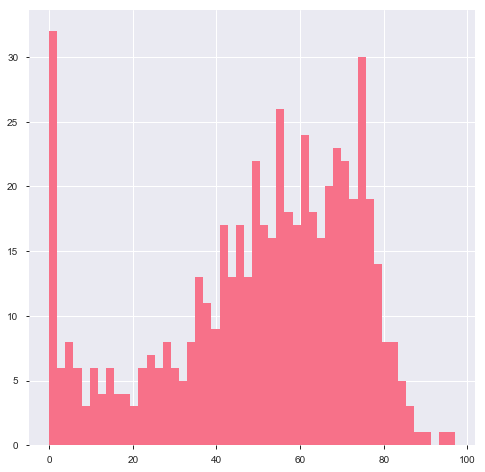

In [225]:
spotify_df.popularity.hist(figsize = [8,8],
                          bins = 50)

We're seeing a lot of zeros (no data). Let's remove them temporarily to dive a little deeper into this metric

In [241]:
temp = spotify_df.loc[spotify_df.popularity > 0]

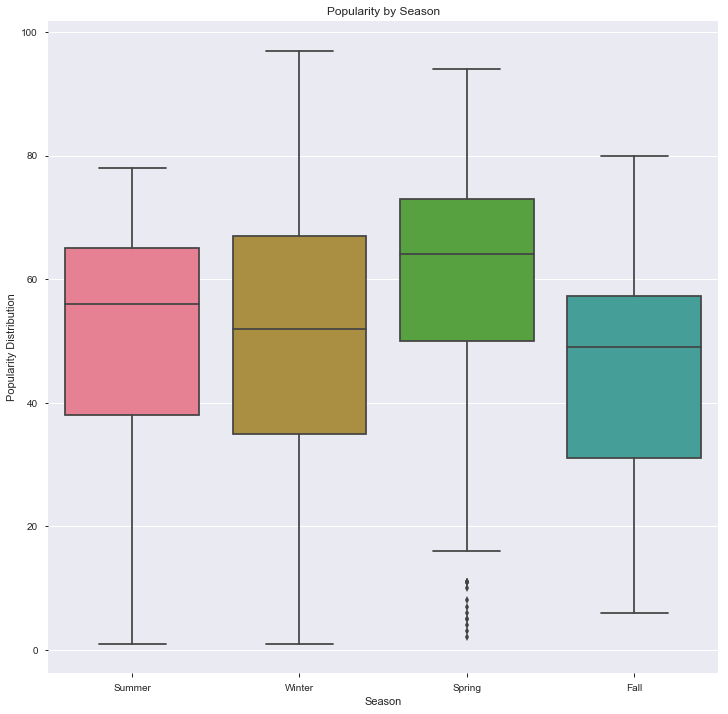

In [249]:
plt.figure(figsize=(12,12))
sns.boxplot(y='popularity',x='seasons', data=temp)
plt.title('Popularity by Season')
plt.xlabel('Season')
plt.ylabel('Popularity Distribution');

In [246]:
# Check significance
# Null: season has no affect on popularity
# Actual: Seaosn has an affect on popularity of music listened to 
results = ols('popularity ~ C(seasons)', data=temp).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     13.47
Date:                Wed, 29 Jan 2020   Prob (F-statistic):           1.73e-08
Time:                        15:01:09   Log-Likelihood:                -2410.5
No. Observations:                 544   AIC:                             4829.
Df Residuals:                     540   BIC:                             4846.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               43.6833      2.634     16.583      0.000      38.509      48.858
C(seasons)[T.Spring]    15.4918      2.976      5.205      0.000       9.645      21.338
C(seasons)[T.Summer]     6.2485      4.050      1.543      0.123      -1.707      14.204
C(seasons)[T.Winter]     5.6620      2.968      1.908      0.057      -0.167      11.491
==============================================================================
Omnibus:                       38.954   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.931
Skew:                          -0.710   Prob(JB):                     1.06e-10
Kurtosis:                       3.085   Cond. No.                         7.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Given the results of this ANOVA, (p value < F - Statistic), I can reject the null hypothesis. I will use a tukey HSD test to see where this significance occurs more clearly 

In [247]:
mc = MultiComparison(temp.popularity, temp.seasons)
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 Fall  Spring 15.4918   7.8218  23.1618  True 
 Fall  Summer  6.2485  -4.1885  16.6855 False 
 Fall  Winter  5.662   -1.9857  13.3096 False 
Spring Summer -9.2433  -17.9374 -0.5492  True 
Spring Winter -9.8298  -14.8441 -4.8156  True 
Summer Winter -0.5865  -9.2609   8.0878 False 
----------------------------------------------


It is Clear that I listen to significantly more popular music in the spring than in any other season! Something about the change in weather maybe

## 2.3 Audio Features

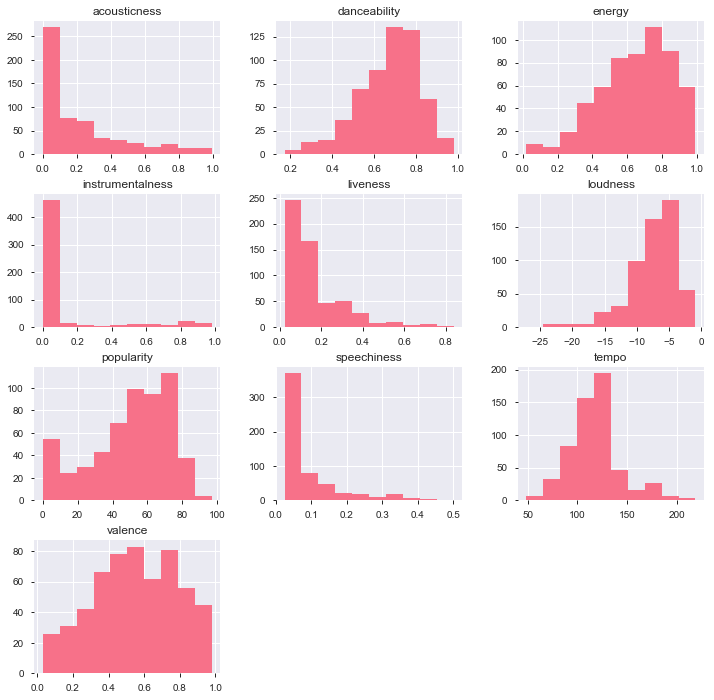

In [397]:
df_cont = df_cont.drop(['duration_ms'], axis = 1)
ax = df_cont.hist(figsize = [12,12])

In [398]:
df_cont.danceability.mean()

0.6704736842105266

Let's look into the variety of my music taste a little more. I want to compare the standard deviations of each feature to see if there are categories where I am more open-minded. Since all audio features are on a scale from 0 - 1, we can look at them all simultaneously. 

In [300]:
df_features = df_cont.drop(['duration_ms', 'tempo', 'popularity'], axis = 1)

In [301]:
df_features.std().mean()

0.18873409879922826

Text(0.5, 1.0, 'Standard Deviation ofAudio Features')

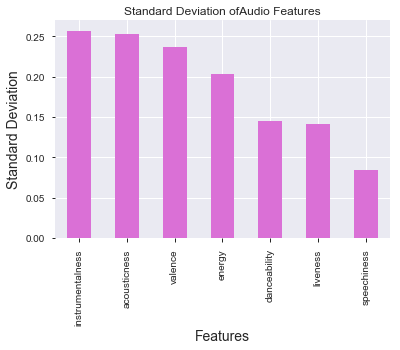

In [305]:
df_features.std() \
    .sort_values(ascending= False) \
    .plot(kind = 'bar', color = 'orchid')

plt.xlabel('Features', fontsize = 14)
plt.ylabel('Standard Deviation', fontsize = 14)
plt.title("Standard Deviation ofAudio Features")

Since Instrumentalness had the high counts of zeros, it's not surprising that it shows up with high standard deviation. Let's remove the zeros and check again:

In [308]:
temp2 = df_features.loc[df_features.instrumentalness > 0]

Text(0.5, 1.0, 'Standard Deviation ofAudio Features')

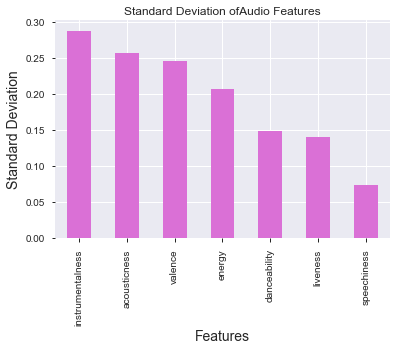

In [309]:
temp2.std() \
    .sort_values(ascending= False) \
    .plot(kind = 'bar', color = 'orchid')

plt.xlabel('Features', fontsize = 14)
plt.ylabel('Standard Deviation', fontsize = 14)
plt.title("Standard Deviation ofAudio Features")

It seems I have a more narrow taste in music when it comes to speechiness, liveness, and danceability, than I do for other features such as instrumentalness, acousticness, or valence. How are these features correlated?

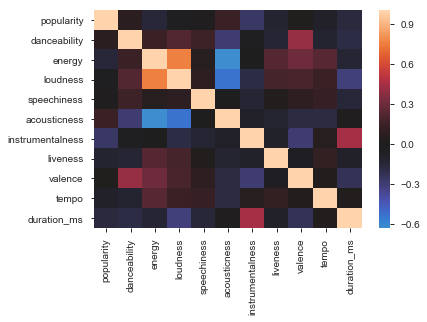

In [312]:
ax = sns.heatmap(df_cont.corr(), center = 0)

Loudness and energy seem highly correlated (keeping in mind for any model building in the future), which makes sense.

In [314]:
df_cont.corr()

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
popularity,1.000000,0.072834,-0.142931,-0.019391,0.013338,0.136595,-0.254435,-0.111472,0.026147,-0.076174,-0.159430
danceability,0.072834,1.000000,0.140580,0.219715,0.150098,-0.291867,-0.034255,-0.130448,0.411354,-0.113511,-0.178834
energy,-0.142931,0.140580,1.000000,0.759959,0.062199,-0.629270,-0.011426,0.224045,0.304959,0.237127,-0.131140
loudness,-0.019391,0.219715,0.759959,1.000000,0.080198,-0.529840,-0.182847,0.179707,0.197399,0.135125,-0.312159
speechiness,0.013338,0.150098,0.062199,0.080198,1.000000,-0.011491,-0.127038,0.032731,0.093127,0.129336,-0.144129
acousticness,0.136595,-0.291867,-0.629270,-0.529840,-0.011491,1.000000,-0.070629,-0.116786,-0.174515,-0.175097,0.010195
instrumentalness,-0.254435,-0.034255,-0.011426,-0.182847,-0.127038,-0.070629,1.000000,-0.086332,-0.286341,0.051101,0.450788
liveness,-0.111472,-0.130448,0.224045,0.179707,0.032731,-0.116786,-0.086332,1.000000,-0.038484,0.109056,-0.080929
valence,0.026147,0.411354,0.304959,0.197399,0.093127,-0.174515,-0.286341,-0.038484,1.000000,0.033448,-0.224104
tempo,-0.076174,-0.113511,0.237127,0.135125,0.129336,-0.175097,0.051101,0.109056,0.033448,1.000000,0.034817


## 2.5 Instrumentalness

If we look at the definition provided by Spotify, songs with 0.5 or higher scores of instrumentalness are intended to represent tracks that are instrumental. Let's check this out a little further:

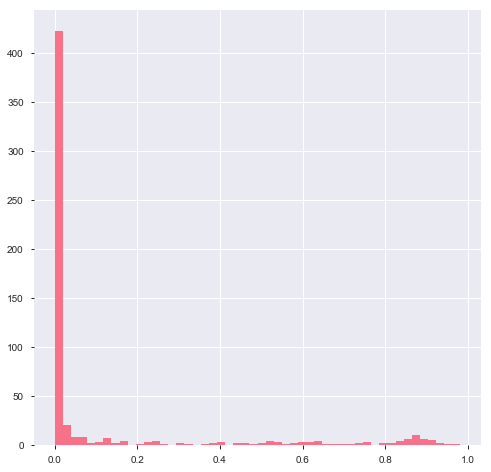

In [363]:
spotify_df.instrumentalness.hist(figsize = [8,8],
                          bins = 50)

In [364]:
spotify_df.instrumentalness.value_counts().head(10)

0.000000    147
0.873000      3
0.000001      3
0.000008      2
0.007610      2
0.130000      2
0.000206      2
0.881000      2
0.000128      2
0.000192      2
Name: instrumentalness, dtype: int64

In [372]:
spotify_df['instrumentalness'].loc[spotify_df['instrumentalness'] > .5].count()

69

Not much instrumental music (highly vocal). We would expect that this would have an effect on the speechiness score ( the presence of spoken words). Let's look at this briefly:

In [368]:
instrumental = []
for i in spotify_df['instrumentalness']:
    if i > .5:
        instrumental.append(1)
    else:
        instrumental.append(0)

In [369]:
spotify_df['instrumental'] = instrumental

(array([ 3., 10.,  9.,  7.,  9.,  4.,  6.,  3.,  3.,  0.,  3.,  1.,  2.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.0285 , 0.03299, 0.03748, 0.04197, 0.04646, 0.05095, 0.05544,
        0.05993, 0.06442, 0.06891, 0.0734 , 0.07789, 0.08238, 0.08687,
        0.09136, 0.09585, 0.10034, 0.10483, 0.10932, 0.11381, 0.1183 ,
        0.12279, 0.12728, 0.13177, 0.13626, 0.14075, 0.14524, 0.14973,
        0.15422, 0.15871, 0.1632 , 0.16769, 0.17218, 0.17667, 0.18116,
        0.18565, 0.19014, 0.19463, 0.19912, 0.20361, 0.2081 , 0.21259,
        0.21708, 0.22157, 0.22606, 0.23055, 0.23504, 0.23953, 0.24402,
        0.24851, 0.253  ]),
 <a list of 50 Patch objects>)

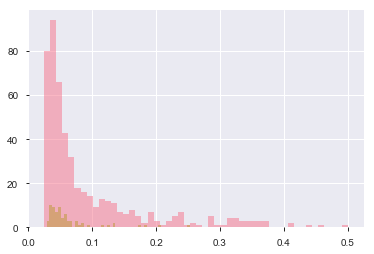

In [382]:
plt.hist(spotify_df['speechiness'].loc[spotify_df['instrumental'] == 0], \
        bins = 50, \
        label = "series 1", \
        alpha = .5)
plt.hist(spotify_df['speechiness'].loc[spotify_df['instrumental'] == 1], \
                bins = 50, \
        label = "series 2", \
        alpha = .5)

There was no apparent pattern here, but it's also using a small dataset that is very bias, so not too worth exploring further

In [395]:
spotify_df['speechiness'].groupby(spotify_df['seasons']).mean()

seasons
Fall      0.083030
Spring    0.083605
Summer    0.086296
Winter    0.097206
Name: speechiness, dtype: float64

## 2.5 Keys

The way Spotify API classifies keys is using Pitch Class notation, where C = 0, C# = 1, D = 2, all the way up to B = 11. The audio features also include mode, which indicates if the key is major or minor (1 and 0 respectively) - thus resulting in 22 possible keys. 

In [280]:
spotify_df.key.value_counts()

0     74
1     66
7     59
2     58
5     56
9     51
8     46
11    45
4     39
6     38
10    30
3      8
Name: key, dtype: int64

In [330]:
spotify_df['mode_written'].value_counts()

Major    356
Minor    214
Name: mode_written, dtype: int64

In [343]:
mode_written = []
for x in spotify_df['mode']:
    if x == 0:
        mode_written.append('Minor')
    else:
        mode_written.append('Major')
spotify_df['mode_written'] = mode_written

In [344]:
spotify_df.head()

,uri,artist,name,popularity,release_date,added_at,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,added_year,added_month,seasons,mode_written
0,spotify:track:6xEHCWUvalb0fNYuAo591v,Rob Araujo,Nineteen,35,2018-10-12,2019-07-09 20:22:42+00:00,0.487,0.787,5,-11.323,...,0.871000,0.1090,0.424,74.916,283200,4,2019,7,Summer,Minor
1,spotify:track:6v96ZIpQUtWMSUqlBlTif6,Rob Araujo,Hike,31,2018-04-03,2019-07-10 14:12:50+00:00,0.567,0.377,0,-11.851,...,0.802000,0.1030,0.563,120.927,227000,3,2019,7,Summer,Minor
2,spotify:track:62VWmsNoDmqT0Mj9oHHFVh,Roy Hargrove,Strasbourg / St. Denis,49,2008-01-01,2019-07-10 15:01:41+00:00,0.701,0.445,1,-10.583,...,0.590000,0.0963,0.405,103.004,278627,4,2019,7,Summer,Major
3,spotify:track:1W97IZUEKOaIVxG7GKJkL6,Anomalie,Velours,46,2017-06-23,2019-07-10 17:28:40+00:00,0.541,0.465,1,-5.325,...,0.895000,0.2550,0.450,178.393,256180,4,2019,7,Summer,Minor
4,spotify:track:0sCeNwt8xRCMR4NhKpMyBe,Herbie Hancock,Cantaloupe Island - Remastered 1999 / Rudy Van...,61,1964-06-17,2019-07-10 17:30:22+00:00,0.515,0.583,0,-8.182,...,0.000294,0.1230,0.415,116.134,333947,4,2019,7,Summer,Minor


It looks like I listen to more Major music than I do minor. Is that affected by the season?

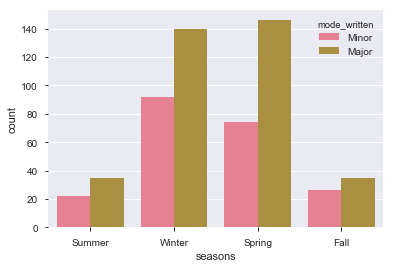

In [288]:
ax = sns.countplot(x = 'seasons', hue = 'mode_written', data = spotify_df)

In [352]:
q = spotify_df \
    .groupby(['seasons','mode_written']) \
    .count()['uri'] \
    .reset_index()

In [353]:
q

,seasons,mode_written,uri
0,Fall,Major,35
1,Fall,Minor,26
2,Spring,Major,146
3,Spring,Minor,74
4,Summer,Major,35
5,Summer,Minor,22
6,Winter,Major,140
7,Winter,Minor,92


In [356]:
def percent_difference(x1, x2):
    y = (x1 - x2) / ((x1+x2)/1)
    return y

In [360]:
percent_difference(35, 26)

0.14754098360655737

Lastly i checked if Valence(mood) was associated with major vs. minor keys

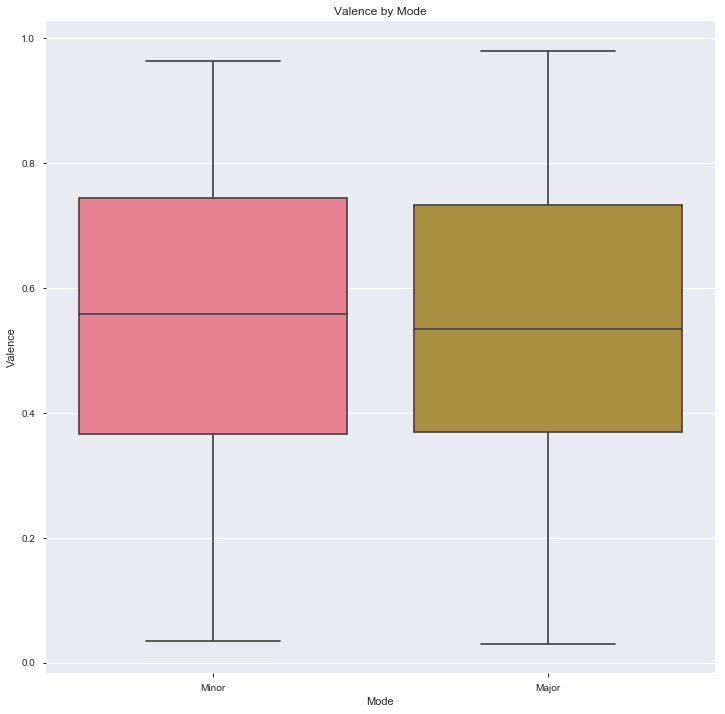

In [331]:
plt.figure(figsize=(12,12))
sns.boxplot(y='valence',x='mode_written', data=spotify_df)
plt.title('Valence by Mode')
plt.xlabel('Mode')
plt.ylabel('Valence');

Null Hypothesis: Modality of the song has no significant effect on the valence of the song

Alternate Hypothesis: Modality of the song has a significant effect on the valence of the song

In [362]:
yes = spotify_df.valence[spotify_df.mode_written == 'Major']
no = spotify_df.valence[spotify_df.mode_written == 'Minor']
ttest_ind(yes, no)

Ttest_indResult(statistic=0.00033559495610034965, pvalue=0.9997323517996521)

there was no significance here (as pretty obvious from the boxplots), however, this is also using a small dataset that is very bias!

# 3. Future Directions

In the future, I could read in the playlists that I frequently listen to that were out of my user scope by manually inputting playlist uris that I know from expereince are frequent in my listening history. I could also save all of my "saved tracks" to a playlist and read that in, instead of using the saved-tracks scope. This would increase the scope of my dataset to include more of the music I listen to.
Additionally, implementing a reccommendation system to come up with a way to see if I would be likely to like a song, and testing it out based off of listening to that music, would be another way to make this analysis more robust.
